In [46]:
"""
Basic 1 column CNN comparing between GFS and RAP data
This is just the inital validation for the CNN model for climate models
More later
Really simple code, but works- my first CNN model
"""
import numpy as np
import pandas as pd
import xarray as xr
# TODO move to top this and CONFIGS
import numpy as np
import xarray as xr
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import logging

# Log config
logging.basicConfig(
    level=logging.INFO,                           
    format="%(asctime)s [%(levelname)s] %(message)s",
    handlers=[
        logging.StreamHandler(),                   
        logging.FileHandler("CNN.log")    
    ]
)

logger = logging.getLogger(__name__)  


EPOCHS = 500


VAR_CHANNELS = ["delta_qv_physics", "delta_t_physics", "plev_channel"]  # add more variables as needed




LEVEL_DIM = "newlev"
TIME_DIM = "time"
SAMPLE_DIM = "sample"


In [47]:
# Data preparation 
def set_time_coordinates(ds, start_time="2016-08-11T00:00", freq="3H"):
    """
    Assigns a real UTC time coordinate to the dataset
    Args:
        ds: Input dataset that has a dimension named 'init_time'.
        start_time: The start timestamp in ISO format (default '2016-08-11T00:00').
        freq: Time step spacing, e.g. '3H' for 3-hourly data.

    Returns:
        ds: Dataset with a new 'time' coordinate and 'init_time' replaced.

    """
    n = ds.sizes["init_time"]
    t0 = np.datetime64(start_time)
    time = pd.date_range(t0, periods=n, freq=freq).to_numpy()

    ds = ds.assign_coords(time=("init_time", time))
    ds = ds.swap_dims({"init_time": "time"})
    return ds


def apply_misc_changes(ds: xr.Dataset) -> xr.Dataset:
    """
    MISC data edits
      1. Removes final 4 timesteps (indices 241–244).
      2. Sets all data at 2016-08-31 18:00 UTC to NaN.

    Args:
        ds: Dataset that has a 'time' coordinate (output of set_time_coordinates).

    Returns
        ds: Modified dataset.
    """
    # Remove final timesteps
    ds = ds.isel(time=slice(0, -4))

    # Set 2016-08-31 18:00 UTC to NaN
    target_time = np.datetime64("2016-08-31T18:00")
    if target_time in ds.time.values:
        ds = ds.copy()  # avoid modifying in-place
        ds.loc[dict(time=target_time)] = np.nan

    return ds



def compute_hourly_level_stats(train_ds: xr.Dataset, time_dim="time", level_dim="newlev", reduce_over=None):
    """
    TODO add datatype in funciton header
    Compute mean/std for each UTC hour × pressure level from TRAIN set.
    Only variables with both time and level dims are handled.
    """
    stats = {}
    for var in train_ds.data_vars:
        da = train_ds[var]
        if (np.issubdtype(da.dtype, np.number) and time_dim in da.dims and level_dim in da.dims):
            reduce_dims = [time_dim]
            if reduce_over:
                reduce_dims = list(dict.fromkeys(reduce_dims + list(reduce_over)))

            g = da.groupby(f"{time_dim}.hour")          # <-- no assign_coords needed
            mean = g.mean(dim=reduce_dims, skipna=True)
            std  = g.std (dim=reduce_dims, skipna=True)

            stats[var] = {"mean": mean, "std": std, "level_dim": level_dim}
    return stats


def apply_hourly_level_normalisation(ds: xr.Dataset, stats: dict, time_dim="time", level_dim="newlev"):
    """
    Apply joint (UTC hour × pressure level) normalisation using TRAIN stats.
    """
    ds_norm = ds.copy()
    hour_idx = xr.DataArray(ds[time_dim].dt.hour.values, dims=time_dim, name="hour")  # <-- values

    for var, s in stats.items():
        if var not in ds_norm:
            continue
        da = ds_norm[var]
        if time_dim in da.dims and level_dim in da.dims:
            mean = s["mean"].sel(hour=hour_idx)
            std  = s["std"].sel(hour=hour_idx)
            safe_std = xr.where((std == 0) | (~np.isfinite(std)), 1.0, std)
            ds_norm[var] = (da - mean) / safe_std
    return ds_norm
#TODO add the moramlisation per plevel!!!!!!

# TODO: maybe remove
def add_positional_channel(ds, p_norm, name="plev_channel"):
    shape = (ds.sizes["sample"], ds.sizes["time"], ds.sizes["newlev"])
    p3 = np.broadcast_to(p_norm, shape).astype("float32")
    da = xr.DataArray(p3, dims=("sample","time","newlev"))
    return ds.assign(**{name: da})

# TODO this is reused below, maybe integrate
def compute_nan_fraction(
    ds: xr.Dataset,
    var_names,
    sample_dim=SAMPLE_DIM,
    time_dim=TIME_DIM,
    level_dim=LEVEL_DIM,
):
    """
    Compute NaN diagnostics for the given variables.
    """
    # Gather per-var arrays shaped [S, T, L]
    arrays = []
    for v in var_names:
        if v in ds and (sample_dim in ds[v].dims and time_dim in ds[v].dims and level_dim in ds[v].dims):
            arrays.append(ds[v].transpose(sample_dim, time_dim, level_dim).values)
        else:
            raise ValueError(f"{v} missing or has wrong dims in dataset.")

    # Stack to [S, T, C, L]
    data = np.stack(arrays, axis=2)

    # Fraction of NaNs over C×L for each (S,T)
    nan_fraction = np.isnan(data).mean(axis=(2, 3))  # [S, T] in [0,1]

    # Any-NaN boolean over channels×levels for each (S,T)
    any_nan_bool = np.isnan(data).any(axis=(2, 3))   # [S, T], True if any missing

    # Wrap as DataArray for convenience
    nan_frac_da = xr.DataArray(
        nan_fraction,
        dims=(sample_dim, time_dim),
        coords={sample_dim: ds[sample_dim], time_dim: ds[time_dim]},
        name="nan_fraction"
    )

    any_nan_da = xr.DataArray(
        any_nan_bool,
        dims=(sample_dim, time_dim),
        coords={sample_dim: ds[sample_dim], time_dim: ds[time_dim]},
        name="has_any_nan"
    )

    # Global stats
    S = data.shape[0]
    T = data.shape[1]
    total_pairs = int(S * T)
    pairs_with_any_nan = int(any_nan_bool.sum())
    pairs_with_any_nan_pct = 100.0 * pairs_with_any_nan / max(1, total_pairs)

    flat = nan_fraction.reshape(-1)
    mean_pct = float(flat.mean() * 100.0)
    std_pct  = float(flat.std()  * 100.0)
    max_pct  = float(flat.max()  * 100.0)

    # Per-sample (# of times with any NaN) and per-time (# of samples with any NaN)
    per_sample_any_nan_count = any_nan_da.sum(dim=time_dim).astype("int64")  # [sample]
    per_time_any_nan_count   = any_nan_da.sum(dim=sample_dim).astype("int64")# [time]

    summary = {
        "mean_%": mean_pct,
        "std_%":  std_pct,
        "max_%":  max_pct,
        "total_pairs": total_pairs,
        "pairs_with_any_nan": pairs_with_any_nan,
        "pairs_with_any_nan_%": pairs_with_any_nan_pct,
        "per_sample_any_nan_count": per_sample_any_nan_count,  # DataArray
        "per_time_any_nan_count":   per_time_any_nan_count,    # DataArray
    }

    # If you also want to keep the boolean grid in the dataset, return it too:
    return nan_frac_da, summary, any_nan_da



def data_processing_pipeline(model_datasets):
    """
    TODO ADD DESCRIPTION-combine normalise
    """

    labelled_datasets = []

    for idx, (name, ds) in enumerate(model_datasets.items()):
        # assign both numeric and string labels
        ds_labeled = ds.assign_coords(model_id=idx, model_name=name)
        labelled_datasets.append(ds_labeled)


    # concatenate along a new dimension 
    ds_combined = xr.concat(labelled_datasets, dim="sample")


    ds_combined = set_time_coordinates(ds_combined)
    ds_combined = apply_misc_changes(ds_combined)


    # Split validation/train
    ds_train = ds_combined.isel(time=slice(0, 176))
    ds_validation  = ds_combined.isel(time=slice(177, 216))
    ds_test  = ds_combined.isel(time=slice(217, 240)) 

    #Normalise
    norm_stats = compute_hourly_level_stats(ds_train)
    ds_train_norm = apply_hourly_level_normalisation(ds_train, norm_stats)
    ds_validation_norm = apply_hourly_level_normalisation(ds_validation, norm_stats)
    ds_test_norm = apply_hourly_level_normalisation(ds_test, norm_stats)

    #Add normalised pressure coord, a height hint for the CNN, note that I think maybe the pooling later will remove some of this info, so this is essentially adding t back in
    p = ds_train_norm["plev"].values.astype("float32")
    p_norm = (p - p.mean()) / (p.std() + 1e-8)

    ds_train_norm = add_positional_channel(ds_train_norm, p_norm, "plev_channel")
    ds_validation_norm  = add_positional_channel(ds_validation_norm,  p_norm, "plev_channel")
    ds_test_norm  = add_positional_channel(ds_test_norm,  p_norm, "plev_channel")

    # NAN stats
    nan_frac_train, train_summary, train_any = compute_nan_fraction(ds_train_norm, VAR_CHANNELS)
    nan_frac_validation,  validation_summary,  validation_any  = compute_nan_fraction(ds_validation_norm,  VAR_CHANNELS)
    nan_frac_test,  test_summary,  test_any  = compute_nan_fraction(ds_test_norm,  VAR_CHANNELS)

    # TODO add nan_frac to ds??

    # Log both % and counts
    logger.info(
        "Train NaN fraction: mean %.2f%% ± %.2f%% (max %.2f%%) | pairs_with_any_nan=%d/%d (%.2f%%)",
        train_summary["mean_%"], train_summary["std_%"], train_summary["max_%"],
        train_summary["pairs_with_any_nan"], train_summary["total_pairs"], train_summary["pairs_with_any_nan_%"]
    )
    logger.info(
        "validation  NaN fraction: mean %.2f%% ± %.2f%% (max %.2f%%) | pairs_with_any_nan=%d/%d (%.2f%%)",
        validation_summary["mean_%"],  validation_summary["std_%"],  validation_summary["max_%"],
        validation_summary["pairs_with_any_nan"], validation_summary["total_pairs"], validation_summary["pairs_with_any_nan_%"]
    )
    logger.info(
        "Test  NaN fraction: mean %.2f%% ± %.2f%% (max %.2f%%) | pairs_with_any_nan=%d/%d (%.2f%%)",
        test_summary["mean_%"],  test_summary["std_%"],  test_summary["max_%"],
        test_summary["pairs_with_any_nan"], test_summary["total_pairs"], test_summary["pairs_with_any_nan_%"]
    )


    

    return ds_train_norm, ds_validation_norm, ds_test_norm





ds_gfs = xr.open_dataset("GFS_merged_latid197.nc")
ds_rap = xr.open_dataset("RAP_merged_latid197.nc")

# For one column for now
target_lon = 51.5
# Pick the nearest grid column at that longitude and drop the lon dimension
gfs_col = ds_gfs.sel(lon=target_lon, method="nearest", drop=True)
rap_col = ds_rap.sel(lon=target_lon, method="nearest", drop=True)


model_datasets = {
    "GFS": gfs_col,
    "RAP": rap_col
}

ds_train, ds_validation, ds_test_norm = data_processing_pipeline(model_datasets)



C:\Users\danna\AppData\Local\Temp\ipykernel_38444\1447201198.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time = pd.date_range(t0, periods=n, freq=freq).to_numpy()
2025-11-10 14:47:47,923 [INFO] Train NaN fraction: mean 0.38% ± 5.01% (max 66.67%) | pairs_with_any_nan=2/352 (0.57%)
2025-11-10 14:47:47,923 [INFO] validation  NaN fraction: mean 0.00% ± 0.00% (max 0.00%) | pairs_with_any_nan=0/78 (0.00%)
2025-11-10 14:47:47,927 [INFO] Test  NaN fraction: mean 0.00% ± 0.00% (max 0.00%) | pairs_with_any_nan=0/46 (0.00%)


In [ ]:
   

#TODO maybe make better and more efficient by merginf build_xy_from_xr to the data pipeline
#  build (X, y) from an xarray.Dataset
def build_xy_from_xr(ds: xr.Dataset, var_names, sample_dim = SAMPLE_DIM, level_dim=LEVEL_DIM, time_dim=TIME_DIM):
    """
    Returns:
      X: np.ndarray of shape [N_examples, C, L]
      y: np.ndarray of shape [N_examples]  (class id from model_id)
    One example per (model, time).
    """
    
    # Safety checks
    # TODO this needed??
    for v in var_names:
        if v not in ds:
            raise ValueError(f"Variable '{v}' not found in dataset.")

    # Extract labels from the dataset coord 'model_id' (per-sample)
    # We will broadcast to (sample, time)
    model_ids = ds["model_id"].values  # shape [n_models]
    n_models = model_ids.shape[0]
    n_times  = ds.sizes[time_dim]
    n_levels = ds.sizes[level_dim]
    n_channels = len(var_names)

    # Stack per (model, time)
    # Build data array per variable -> shape [sample, time, newlev]
    arrays = []
    for v in var_names:
        a = ds[v].transpose(sample_dim, time_dim, level_dim).values  # [S, T, L]
        arrays.append(a)
    # Stack channels -> [S, T, C, L]
    data = np.stack(arrays, axis=2)

    # Flatten (model, time) -> N examples
    X = data.reshape(n_models * n_times, n_channels, n_levels)

    # Label per (model, time): repeat model_id across time
    y = np.repeat(model_ids, n_times)


    # TODO make smth more sophsitcated maybe by adding another channel
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

    return X.astype(np.float32), y.astype(np.int64)

X_train, y_train = build_xy_from_xr(ds_train, VAR_CHANNELS)
X_validation,  y_validation  = build_xy_from_xr(ds_validation,  VAR_CHANNELS)
X_test,  y_test  = build_xy_from_xr(ds_test_norm,  VAR_CHANNELS)

logger.info(f"Train: X={X_train.shape} y={y_train.shape}")
logger.info(f"Validation: X={X_validation.shape} y={y_validation.shape}")
logger.info(f"Test: X={X_test.shape} y={y_test.shape}")

# TODO not sure but proabbaly can be merged witg data loader
class ColumnDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)  
        self.y = torch.from_numpy(y)  

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = ColumnDataset(X_train, y_train)
validation_ds  = ColumnDataset(X_validation,  y_validation)
test_ds  = ColumnDataset(X_test,  y_test)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
validation_loader  = DataLoader(validation_ds,  batch_size=256, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False)


# Input: [B, C, L] where C=#channels (2 here), L=#levels (46)

num_classes = len(np.unique(y_train))

class SimpleLevelCNN(nn.Module):
    def __init__(self, in_channels, n_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(in_channels, 16, kernel_size=15, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(16),

            # TODO separate out CNN blocks into different things, like self.block2
            nn.Conv1d(16, 32, kernel_size=15, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(32),

            nn.AdaptiveAvgPool1d(1),  
            # TODO separate out CNN blocks into different things, like self.block2

        )
        self.head = nn.Linear(32, n_classes)

    def forward(self, x):
        z = self.net(x)           # [B, 32, 1]
        z = z.squeeze(-1)         # [B, 32]
        logits = self.head(z)     # [B, n_classes]
        return logits

class EarlyStopping:
    def __init__(self, patience=20, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.count = 0
        self.best_state = None

    def step(self, val_loss, model):
        improved = (self.best - val_loss) > self.min_delta
        if improved:
            self.best = val_loss
            self.count = 0

        else:
            self.count += 1
        return self.count >= self.patience




def evaluate(loader):
    model.eval()
    correct, total, loss_sum = 0, 0, 0.0
    with torch.no_grad():
        for Xb, yb in loader:
            Xb, yb = Xb.to(device), yb.to(device)
            logits = model(Xb)
            loss = criterion(logits, yb)
            loss_sum += loss.item() * yb.size(0)

            preds = logits.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)

    avg_loss = loss_sum / total
    accuracy = correct / total
    return avg_loss, accuracy


# TODO NEATEN


model = SimpleLevelCNN(in_channels=len(VAR_CHANNELS), n_classes=num_classes)

# Train
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.05) 
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',      # CHECK other options
    factor=0.5,      # divide LR by 2
    patience=20,     # "every 10 if not improved"
    min_lr=1e-6
)
early_stop = EarlyStopping(patience=40, min_delta=0.0)

best_val_acc = 0.0
epochs = EPOCHS

for epoch in range(1, epochs + 1):
    model.train()
    running = 0.0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(Xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running += loss.item() * yb.size(0)

    train_loss = running / len(train_ds)
    val_loss, val_acc = evaluate(validation_loader)

    # Step the LR scheduler based on validation loss
    scheduler.step(val_loss)

    
    current_lr = optimizer.param_groups[0]['lr']
    logger.info(
        f"Epoch {epoch:02d}, train_loss={train_loss:.4f}, validation_loss={val_loss:.4f}, validation_acc={val_acc:.3f}, {current_lr:.3f}"
    )

    #Early stopping check
    should_stop = early_stop.step(val_loss, model)
    if should_stop:
        logger.info(f"Early stopping at epoch {epoch}")
        break



# Evaluation
model.eval()

# Full test-set metrics

test_loss, test_acc = evaluate(test_loader)
logger.info("FINAL TEST | loss=%.4f | acc=%.3f", test_loss, test_acc)






2025-11-10 14:47:48,808 [INFO] Train: X=(352, 3, 46) y=(352,)
2025-11-10 14:47:48,809 [INFO] Validation: X=(78, 3, 46) y=(78,)
2025-11-10 14:47:48,810 [INFO] Test: X=(46, 3, 46) y=(46,)
2025-11-10 14:47:48,845 [INFO] Epoch 01, train_loss=0.6796, validation_loss=0.6983, validation_acc=0.500, 0.001
2025-11-10 14:47:48,871 [INFO] Epoch 02, train_loss=0.6338, validation_loss=0.7013, validation_acc=0.500, 0.001
2025-11-10 14:47:48,895 [INFO] Epoch 03, train_loss=0.6018, validation_loss=0.7028, validation_acc=0.526, 0.001
2025-11-10 14:47:48,919 [INFO] Epoch 04, train_loss=0.5725, validation_loss=0.6971, validation_acc=0.538, 0.001
2025-11-10 14:47:48,938 [INFO] Epoch 05, train_loss=0.5475, validation_loss=0.6853, validation_acc=0.538, 0.001
2025-11-10 14:47:48,968 [INFO] Epoch 06, train_loss=0.5234, validation_loss=0.6780, validation_acc=0.551, 0.001
2025-11-10 14:47:48,988 [INFO] Epoch 07, train_loss=0.4968, validation_loss=0.6695, validation_acc=0.641, 0.001
2025-11-10 14:47:49,018 [INFO]

In [34]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models

import captum
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz

import os, sys
import json

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import torch
from captum.attr import IntegratedGradients


In [35]:
validation_model = model.eval()
validation_example = ds_validation.isel(sample=-1, time=-1)
integrated_gradients = IntegratedGradients(validation_model)

In [50]:
import torch
from captum.attr import IntegratedGradients

# Example column for integrated gradients
x_np = X_test[-1]                        
y_np = y_test[-1]                      

# Shape model expects
input_img = torch.from_numpy(x_np[None, ...])      


#  (Optional) compute the predicted class to use as target 
model.eval()
with torch.no_grad():
    logits = model(input_img)          
pred_label_idx = int(torch.softmax(logits, dim=1).argmax(dim=1).item())

#  Integrated Gradients 
integrated_gradients = IntegratedGradients(model)
baseline = torch.zeros_like(input_img)   # standard zero baseline; change if you prefer

pred_label_idx = int(torch.argmax(logits, dim=1).item())

attributions_ig = integrated_gradients.attribute(
    input_img,
    baselines=baseline,
    target=pred_label_idx,               # or replace with your chosen class index
    n_steps=200
)

print("input_img shape:", tuple(input_img.shape))
print("attributions_ig shape:", tuple(attributions_ig.shape))


input_img shape: (1, 3, 46)
attributions_ig shape: (1, 3, 46)


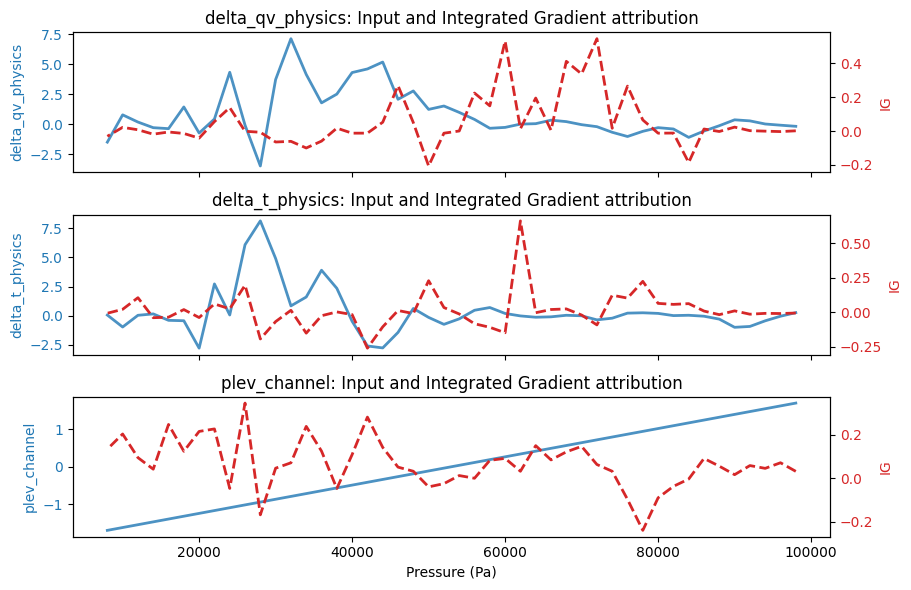

In [51]:
import matplotlib.pyplot as plt


# Prepare array
attr = attributions_ig
if attr.dim() == 4:   # (1, C, 1, L)
    attr = attr.squeeze(0).squeeze(0)   # -> (C, L)
elif attr.dim() == 3: # (1, C, L)
    attr = attr.squeeze(0)
else:
    raise ValueError(f"Unexpected attr shape: {tuple(attr.shape)}")

attr_np = attr.detach().cpu().numpy()        # shape (C, L)
x_np = X_validation[-1]                            # actual variable values for the same sample (C, L)

var_names = VAR_CHANNELS


plev = ds_validation["plev"].values.astype(float)
x_vals = plev
x_label = "Pressure (Pa)"


# Plot variable input and IG attribution
n_channels = len(var_names)
fig, axes = plt.subplots(n_channels, 1, figsize=(9, 2*n_channels), sharex=True)

for i, name in enumerate(var_names):
    ax = axes[i] if n_channels > 1 else axes
    ax2 = ax.twinx()

    # Plot the actual variable value
    ax.plot(x_vals, x_np[i], color="tab:blue", label="Input value", linewidth=2, alpha=0.8)
    ax.set_ylabel(name, color="tab:blue")
    ax.tick_params(axis='y', labelcolor="tab:blue")

    # Overlay the signed IG attribution
    ax2.plot(x_vals, attr_np[i], color="tab:red", linestyle="--", label="IG attribution", linewidth=2)
    ax2.tick_params(axis='y', labelcolor="tab:red")
    ax2.set_ylabel("IG", color="tab:red")

    ax.set_title(f"{name}: Input and Integrated Gradient attribution")

axes[-1].set_xlabel(x_label)
plt.tight_layout()
plt.show()


In [ ]:
"""
Take absolute value of attributions and plot
add the moramlisation per level!!!!!!
DO some analysis of IG
95% spread, mean std
Even do it diruanl  

Will have small training set- rerun 20 times for CNN and take mean and etc.
Thisaffects IG plot -  do analysis

FOr cluster access:
putty
mobaxterm


"""

In [ ]:
ignore below

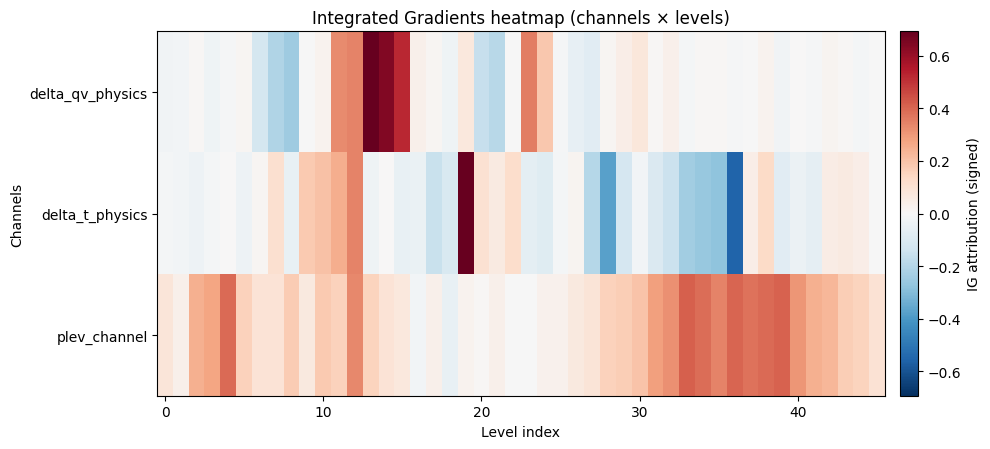

In [12]:
import torch
import numpy as np

# Squeeze batch 
attr = attributions_ig
if attr.dim() == 4:   # (1, C, 1, L)
    attr = attr.squeeze(0).squeeze(0)   # -> (C, L)
elif attr.dim() == 3: # (1, C, L)
    attr = attr.squeeze(0)              # -> (C, L)
else:
    raise ValueError(f"Unexpected attr shape: {tuple(attr.shape)}")

attr_np = attr.detach().cpu().numpy()          # signed attributions (C, L)
attr_abs = np.abs(attr_np)                      # magnitudes
level_importance = attr_abs.sum(axis=0)         # (L,) total per level
channel_importance = attr_abs.sum(axis=1)       # (C,) total per channel

import matplotlib.pyplot as plt

C, L = attr_np.shape
vmax = np.percentile(np.abs(attr_np), 99) or 1.0  # robust color scaling

plt.figure(figsize=(10, 4 + 0.2*C))
im = plt.imshow(attr_np, aspect='auto', cmap='RdBu_r', vmin=-vmax, vmax=vmax)
plt.colorbar(im, fraction=0.025, pad=0.02, label='IG attribution (signed)')
plt.xlabel('Level index')
plt.ylabel('Channels')

# If you have VAR_CHANNELS list, label rows:
try:
    from math import isfinite
    plt.yticks(ticks=np.arange(C), labels=VAR_CHANNELS)
except Exception:
    pass

plt.title('Integrated Gradients heatmap (channels × levels)')
plt.tight_layout()
plt.show()



In [ ]:
ds_test_norm

In [ ]:
print(gfs_col["newlev"].values)


In [ ]:
print(rap_col["newlev"].values)

In [ ]:
ds= gfs_col

In [ ]:
import matplotlib.pyplot as plt

var = "delta_t_dynamics"            # or "delta_t_physics"
it  = 0                             # choose an init_time index (e.g., 0)

ycoord = "newlev"                   # vertical coord to plot against
x      = ds[var].isel(init_time=it)
y      = ds[ycoord]

plt.figure(figsize=(6,5))
plt.plot(x, y)
plt.xlabel("Temperature tendency (K/day)")   # adjust units/label if needed
plt.ylabel(ycoord)
plt.title(f"{var} profile at init_time={ds.init_time.values[it]}")
plt.grid(True)
plt.show()


In [ ]:
gfs_col


In [ ]:
ds_validation

In [ ]:
# TODO move to top this and CONFIGS
import numpy as np
import xarray as xr
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader




VAR_CHANNELS = ["delta_qv_physics", "delta_t_physics", "plev_channel"]  # add more variables as needed




LEVEL_DIM = "newlev"
TIME_DIM = "time"
SAMPLE_DIM = "sample"   

#TODO maybe make better and more efficient by merginf build_xy_from_xr to the data pipeline
#  build (X, y) from an xarray.Dataset
def build_xy_from_xr(ds: xr.Dataset, var_names, sample_dim = SAMPLE_DIM, level_dim=LEVEL_DIM, time_dim=TIME_DIM):
    """
    Returns:
      X: np.ndarray of shape [N_examples, C, L]
      y: np.ndarray of shape [N_examples]  (class id from model_id)
    One example per (model, time).
    """
    
    # Safety checks
    # TODO this needed??
    for v in var_names:
        if v not in ds:
            raise ValueError(f"Variable '{v}' not found in dataset.")

    # Extract labels from the dataset coord 'model_id' (per-sample)
    # We will broadcast to (sample, time)
    model_ids = ds["model_id"].values  # shape [n_models]
    n_models = model_ids.shape[0]
    n_times  = ds.sizes[time_dim]
    n_levels = ds.sizes[level_dim]
    n_channels = len(var_names)

    # Stack per (model, time)
    # Build data array per variable -> shape [sample, time, newlev]
    arrays = []
    for v in var_names:
        a = ds[v].transpose(sample_dim, time_dim, level_dim).values  # [S, T, L]
        arrays.append(a)
    # Stack channels -> [S, T, C, L]
    data = np.stack(arrays, axis=2)

    # Flatten (model, time) -> N examples
    X = data.reshape(n_models * n_times, n_channels, n_levels)

    # Label per (model, time): repeat model_id across time
    y = np.repeat(model_ids, n_times)


    # TODO make smth more sophsitcated maybe by adding another channel
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

    return X.astype(np.float32), y.astype(np.int64)

X_train, y_train = build_xy_from_xr(ds_train, VAR_CHANNELS)
X_validation,  y_validation  = build_xy_from_xr(ds_validation,  VAR_CHANNELS)

print("Train:", X_train.shape, y_train.shape)
print("validation :", X_validation.shape,  y_validation.shape)

# TODO not sure but proabbaly can be merged witg data loader
class ColumnDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)  # float32
        self.y = torch.from_numpy(y)  # int64

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = ColumnDataset(X_train, y_train)
validation_ds  = ColumnDataset(X_validation,  y_validation)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
validation_loader  = DataLoader(validation_ds,  batch_size=256, shuffle=False)


# Input: [B, C, L] where C=#channels (2 here), L=#levels (46)

num_classes = len(np.unique(y_train))

class SimpleLevelCNN(nn.Module):
    def __init__(self, in_channels, n_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(in_channels, 16, kernel_size=15, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(16),

            # TODO separate out CNN blocks into different things, like self.block2
            nn.Conv1d(16, 32, kernel_size=15, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(32),

            nn.AdaptiveAvgPool1d(1),  
            # TODO separate out CNN blocks into different things, like self.block2

        )
        self.head = nn.Linear(32, n_classes)

    def forward(self, x):
        z = self.net(x)           # [B, 32, 1]
        z = z.squeeze(-1)         # [B, 32]
        logits = self.head(z)     # [B, n_classes]
        return logits

model = SimpleLevelCNN(in_channels=len(VAR_CHANNELS), n_classes=num_classes)

# Train
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.05) 
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 500

def evaluate(loader):
    model.eval()
    correct, total, loss_sum = 0, 0, 0.0
    with torch.no_grad():
        for Xb, yb in loader:
            Xb, yb = Xb.to(device), yb.to(device)
            logits = model(Xb)
            loss = criterion(logits, yb)
            loss_sum += loss.item() * yb.size(0)

            preds = logits.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    return loss_sum / total, correct / total

for epoch in range(1, epochs + 1):
    model.train()
    running = 0.0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(Xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running += loss.item() * yb.size(0)

    train_loss = running / len(train_ds)
    val_loss, val_acc = evaluate(validation_loader)
    print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} | validation_loss={val_loss:.4f} | validation_acc={val_acc:.3f}")

# Check
model.eval()
with torch.no_grad():
    Xb, yb = next(iter(validation_loader))
    Xb = Xb.to(device)
    logits = model(Xb)
    preds = logits.argmax(dim=1).cpu().numpy()

print("First 10 true vs pred:", list(zip(yb[:100].numpy(), preds[:100])))


In [ ]:
# TODO move to top this and CONFIGS
import numpy as np
import xarray as xr
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader




VAR_CHANNELS = ["delta_qv_physics", "delta_t_physics", "plev_channel"]  # add more variables as needed




LEVEL_DIM = "newlev"
TIME_DIM = "time"
SAMPLE_DIM = "sample"   

#TODO maybe make better and more efficient by merginf build_xy_from_xr to the data pipeline
#  build (X, y) from an xarray.Dataset
def build_xy_from_xr(ds: xr.Dataset, var_names, sample_dim = SAMPLE_DIM, level_dim=LEVEL_DIM, time_dim=TIME_DIM):
    """
    Returns:
      X: np.ndarray of shape [N_examples, C, L]
      y: np.ndarray of shape [N_examples]  (class id from model_id)
    One example per (model, time).
    """
    
    # Safety checks
    # TODO this needed??
    for v in var_names:
        if v not in ds:
            raise ValueError(f"Variable '{v}' not found in dataset.")

    # Extract labels from the dataset coord 'model_id' (per-sample)
    # We will broadcast to (sample, time)
    model_ids = ds["model_id"].values  # shape [n_models]
    n_models = model_ids.shape[0]
    n_times  = ds.sizes[time_dim]
    n_levels = ds.sizes[level_dim]
    n_channels = len(var_names)

    # Stack per (model, time)
    # Build data array per variable -> shape [sample, time, newlev]
    arrays = []
    for v in var_names:
        a = ds[v].transpose(sample_dim, time_dim, level_dim).values  # [S, T, L]
        arrays.append(a)
    # Stack channels -> [S, T, C, L]
    data = np.stack(arrays, axis=2)

    # Flatten (model, time) -> N examples
    X = data.reshape(n_models * n_times, n_channels, n_levels)

    # Label per (model, time): repeat model_id across time
    y = np.repeat(model_ids, n_times)

    # Replace NaNs with 0 -HMMMMM I'm not sure I like this, maybe should dropsample alltogether
    # TODO again it seems like especially this should be in the data pipeline
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

    return X.astype(np.float32), y.astype(np.int64)

X_train, y_train = build_xy_from_xr(ds_train, VAR_CHANNELS)
X_validation,  y_validation  = build_xy_from_xr(ds_validation,  VAR_CHANNELS)

In [ ]:
X_train

In [ ]:
"""
Callbacks- early stopping- every 20, learnign rate- every 10- divide by 2 if not improved
Have validaiton data- 5 days. validation is completely unseen

Create pliots for one column exmaple
Work on XAI for this column- integrated gradients or grad cam- represent on plot of column with colours smth lie that. Former probs better
"""
#notes
#one var at a time

In [ ]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models

import captum
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz

import os, sys
import json

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


In [ ]:
validation_model = model.eval()
validation_example = ds_validation.isel(sample=-1, time=-1)

In [ ]:
integrated_gradients = IntegratedGradients(validation_model)

In [ ]:
import torch
from captum.attr import IntegratedGradients

# ---- Build the single-example input tensor ----
x_np = X_validation[-1]                        # shape (C, L)
y_np = y_validation[-1]                        # scalar label (optional)

# Choose the shape your model expects:
# If model expects (B, C, L) [Conv1d or linear over levels]:
input_img = torch.from_numpy(x_np[None, ...])         # (1, C, L)

# If model expects (B, C, T, L) [Conv2d with a time axis], use this instead:
# input_img = torch.from_numpy(x_np[None, :, None, :])  # (1, C, 1, L)

device = next(model.parameters()).device
input_img = input_img.to(device).requires_grad_(True)

# ---- (Optional) compute the predicted class to use as target ----
model.eval()
with torch.no_grad():
    logits = model(input_img)            # e.g. (1, num_classes)
pred_label_idx = int(torch.softmax(logits, dim=1).argmax(dim=1).item())

# ---- Integrated Gradients ----
integrated_gradients = IntegratedGradients(model)
baseline = torch.zeros_like(input_img)   # standard zero baseline; change if you prefer

pred_label_idx = int(torch.argmax(logits, dim=1).item())

attributions_ig = integrated_gradients.attribute(
    input_img,
    baselines=baseline,
    target=pred_label_idx,               # or replace with your chosen class index
    n_steps=200
)

print("input_img shape:", tuple(input_img.shape))
print("attributions_ig shape:", tuple(attributions_ig.shape))


In [ ]:
import torch
import numpy as np

# Squeeze batch (and optional time) -> (C, L)
attr = attributions_ig
if attr.dim() == 4:   # (1, C, 1, L)
    attr = attr.squeeze(0).squeeze(0)   # -> (C, L)
elif attr.dim() == 3: # (1, C, L)
    attr = attr.squeeze(0)              # -> (C, L)
else:
    raise ValueError(f"Unexpected attr shape: {tuple(attr.shape)}")

attr_np = attr.detach().cpu().numpy()          # signed attributions (C, L)
attr_abs = np.abs(attr_np)                      # magnitudes
level_importance = attr_abs.sum(axis=0)         # (L,) total per level
channel_importance = attr_abs.sum(axis=1)       # (C,) total per channel

import matplotlib.pyplot as plt

C, L = attr_np.shape
vmax = np.percentile(np.abs(attr_np), 99) or 1.0  # robust color scaling

plt.figure(figsize=(10, 4 + 0.2*C))
im = plt.imshow(attr_np, aspect='auto', cmap='RdBu_r', vmin=-vmax, vmax=vmax)
plt.colorbar(im, fraction=0.025, pad=0.02, label='IG attribution (signed)')
plt.xlabel('Level index')
plt.ylabel('Channels')

# If you have VAR_CHANNELS list, label rows:
try:
    from math import isfinite
    plt.yticks(ticks=np.arange(C), labels=VAR_CHANNELS)
except Exception:
    pass

plt.title('Integrated Gradients heatmap (channels × levels)')
plt.tight_layout()
plt.show()



In [ ]:
import matplotlib.pyplot as plt

C, L = attr_np.shape
vmax = np.percentile(np.abs(attr_np), 99) or 1.0  # robust color scaling

plt.figure(figsize=(10, 4 + 0.2*C))
im = plt.imshow(attr_np, aspect='auto', cmap='RdBu_r', vmin=-vmax, vmax=vmax)
plt.colorbar(im, fraction=0.025, pad=0.02, label='IG attribution (signed)')
plt.xlabel('Level index')
plt.ylabel('Channels')

# If you have VAR_CHANNELS list, label rows:
try:
    from math import isfinite
    plt.yticks(ticks=np.arange(C), labels=VAR_CHANNELS)
except Exception:
    pass

plt.title('Integrated Gradients heatmap (channels × levels)')
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# --- 1️⃣ Prepare attribution array (handles (1,C,L) or (1,C,1,L)) ---
attr = attributions_ig
if attr.dim() == 4:   # (1, C, 1, L)
    attr = attr.squeeze(0).squeeze(0)   # -> (C, L)
elif attr.dim() == 3: # (1, C, L)
    attr = attr.squeeze(0)
else:
    raise ValueError(f"Unexpected attr shape: {tuple(attr.shape)}")

attr_np = attr.detach().cpu().numpy()        # shape (C, L)
x_np = X_validation[-1]                            # actual variable values for the same sample (C, L)

# --- 2️⃣ Get variable names ---
try:
    var_names = VAR_CHANNELS
except NameError:
    var_names = [f"ch{i}" for i in range(attr_np.shape[0])]

# --- 3️⃣ Optional: get vertical coordinate for the x-axis ---
try:
    plev = ds_validation["plev"].values.astype(float)
    x_vals = plev
    x_label = "Pressure (Pa)"
except Exception:
    x_vals = np.arange(attr_np.shape[1])
    x_label = "Level index"

# --- 4️⃣ Plot each variable’s input + IG attribution ---
n_channels = len(var_names)
fig, axes = plt.subplots(n_channels, 1, figsize=(9, 2*n_channels), sharex=True)

for i, name in enumerate(var_names):
    ax = axes[i] if n_channels > 1 else axes
    ax2 = ax.twinx()

    # Plot the actual variable value
    ax.plot(x_vals, x_np[i], color="tab:blue", label="Input value", linewidth=2, alpha=0.8)
    ax.set_ylabel(name, color="tab:blue")
    ax.tick_params(axis='y', labelcolor="tab:blue")

    # Overlay the signed IG attribution
    ax2.plot(x_vals, attr_np[i], color="tab:red", linestyle="--", label="IG attribution", linewidth=2)
    ax2.tick_params(axis='y', labelcolor="tab:red")
    ax2.set_ylabel("IG", color="tab:red")

    ax.set_title(f"{name}: Input vs Integrated Gradient attribution")

axes[-1].set_xlabel(x_label)
plt.tight_layout()
plt.show()


In [ ]:
attributions_ig = integrated_gradients.attribute(validation_example, target='newlev', n_steps=200)

In [ ]:
validation_example

In [ ]:
validationing

In [ ]:
X_train[0]

In [ ]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, classification_report


model.eval()
all_preds = []
all_probs = []
all_true  = []

with torch.no_grad():
    for Xb, yb in validation_loader:
        Xb = Xb.to(device)
        logits = model(Xb)                      # [B, num_classes]
        probs  = torch.softmax(logits, dim=1)   # convert to probabilities
        preds  = probs.argmax(dim=1).cpu().numpy()

        all_preds.append(preds)
        all_probs.append(probs.cpu().numpy())
        all_true.append(yb.numpy())

y_pred = np.concatenate(all_preds, axis=0)
y_prob = np.concatenate(all_probs, axis=0)      # shape [N, num_classes]
y_true = np.concatenate(all_true,  axis=0)
# Build a mapping from model_id -> model_name using coords in your xarray dataset
# These coords live on the `sample` dimension and are consistent across time.
id_to_name = {int(i): str(n) for i, n in zip(ds_validation["model_id"].values, ds_validation["model_name"].values)}
class_ids = sorted(id_to_name.keys())
class_names = [id_to_name[i] for i in class_ids]

print("Classes:", dict(zip(class_ids, class_names)))
cm_counts = confusion_matrix(y_true, y_pred, labels=class_ids)              # integer counts
cm_rownorm = cm_counts.astype(float) / cm_counts.sum(axis=1, keepdims=True) # each row sums to 1

print("Confusion matrix (counts):\n", cm_counts)
print("\nClassification report:\n", classification_report(y_true, y_pred, labels=class_ids, target_names=class_names, digits=3))



In [ ]:
gfs_col

In [ ]:
ds_train